In [1]:
!git clone https://github.com/colome8/DAE-VAE.git

Cloning into 'DAE-VAE'...
remote: Enumerating objects: 989, done.
remote: Counting objects: 100% (989/989), done.
remote: Compressing objects: 100% (719/719), done.
remote: Total 989 (delta 271), reused 984 (delta 270), pack-reused 0 (from 0)
Receiving objects: 100% (989/989), 6.34 MiB | 8.86 MiB/s, done.
Resolving deltas: 100% (271/271), done.


In [58]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
# Install wandb with Keras support:
!pip install wandb -U -q # upgrade wandb to latest version
import wandb.keras
from wandb.keras import WandbCallback

In [2]:

# Definir parámetros
IMG_SIZE = (128, 128)  # Tamaño estándar de imagen
DATASET_PATH = "/content/DAE-VAE/filtered_images"  # Ruta en Google Colab

# Función para cargar y preprocesar imágenes
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0  # Normalización (0-1)
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error cargando imagen {filename}: {e}")
    return images, labels

In [9]:

# Cargar imágenes de ambas clases
apples_images, apples_labels = load_images_from_folder(os.path.join(DATASET_PATH, "apples"), label=0)
bananas_images, bananas_labels = load_images_from_folder(os.path.join(DATASET_PATH, "bananas"), label=1)

# Combinar datos
X = np.array(apples_images + bananas_images)
y = np.array(apples_labels + bananas_labels)

# Dividir en conjunto de entrenamiento (70%), validación (15%) y prueba (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Guardar datos preprocesados en formato .npz
np.savez_compressed("/content/preprocessed_dataset.npz", X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)

print("✅ Preprocesamiento completado. Dataset guardado como 'preprocessed_dataset.npz'")

✅ Preprocesamiento completado. Dataset guardado como 'preprocessed_dataset.npz'


In [10]:
def add_noise(images, noise_type="gaussian", mean=0, var=0.01, salt_prob=0.02, pepper_prob=0.02):
    noisy = []
    for img in images:
        if noise_type == "gaussian":
            row, col, ch = img.shape
            sigma = var ** 0.5
            gauss = np.random.normal(mean, sigma, (row, col, ch))
            noisy_img = img + gauss
            noisy_img = np.clip(noisy_img, 0, 1)
        elif noise_type == "salt_pepper":
            noisy_img = np.copy(img)
            total_pixels = img.shape[0] * img.shape[1]
            num_salt = int(total_pixels * salt_prob)
            coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape[:2]]
            noisy_img[coords[0], coords[1], :] = 1
            num_pepper = int(total_pixels * pepper_prob)
            coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape[:2]]
            noisy_img[coords[0], coords[1], :] = 0
        else:
            noisy_img = img  # no noise
        noisy.append(noisy_img)
    return np.array(noisy)


In [11]:
# 📦 Agregar ruido a las imágenes
X_train_noisy = add_noise(X_train, noise_type="gaussian")
X_val_noisy   = add_noise(X_val, noise_type="gaussian")
X_test_noisy  = add_noise(X_test, noise_type="gaussian")b


In [13]:
def build_autoencoder(input_shape=(128, 128, 3)):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

    autoencoder = keras.Model(inputs, decoded)
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.compile(optimizer="adam", loss="mse")


In [14]:
# Asume que ya tienes: X_train, X_val, X_train_noisy, X_val_noisy
history = autoencoder.fit(
    X_train_noisy, X_train,
    validation_data=(X_val_noisy, X_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - loss: 0.0960 - val_loss: 0.0449
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 0.0394 - val_loss: 0.0271
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 0.0232 - val_loss: 0.0183
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0203 - val_loss: 0.0165
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 0.0156 - val_loss: 0.0136
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0127 - val_loss: 0.0119
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - loss: 0.0118 - val_loss: 0.0111
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - loss: 0.0106 - val_loss: 0.0104
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0105 - val_loss: 0.0100
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0098 - val_loss: 0.0106


In [16]:
import matplotlib.pyplot as plt

def mostrar_resultados(idx=0):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Imagen original
    axs[0].imshow(X_test[idx])
    axs[0].set_title("Original")
    axs[0].axis("off")

    # Imagen con ruido
    axs[1].imshow(X_test_noisy[idx])
    axs[1].set_title("Con ruido")
    axs[1].axis("off")

    # Imagen restaurada por el modelo
    restored = autoencoder.predict(X_test_noisy[idx:idx+1])[0]
    axs[2].imshow(restored)
    axs[2].set_title("Restaurada")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


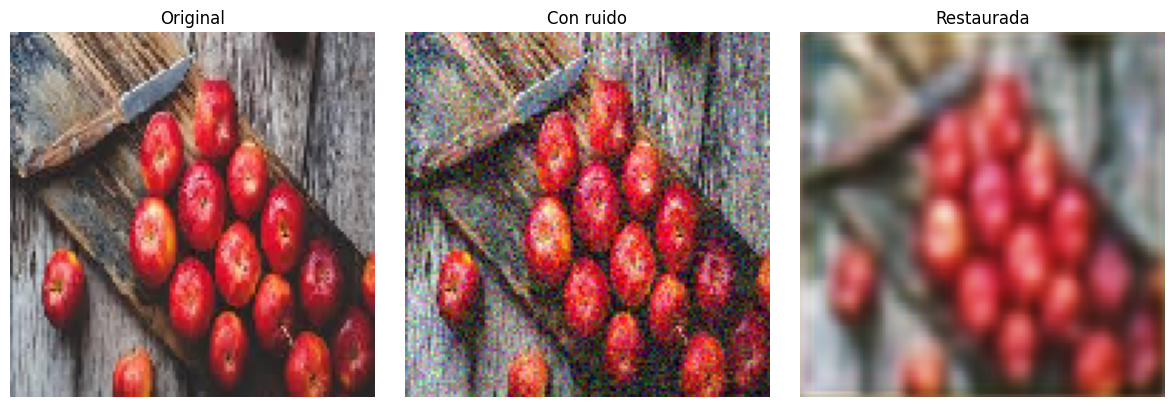

In [22]:
mostrar_resultados(81)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


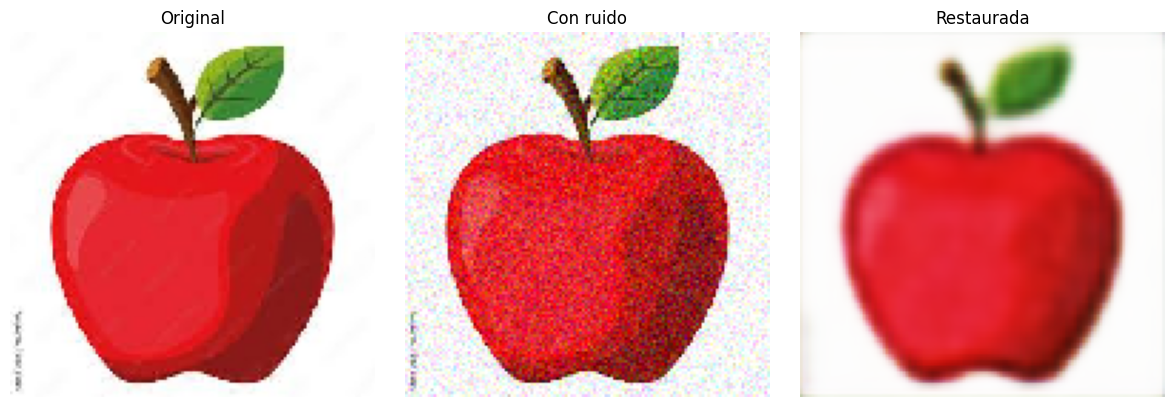

In [31]:
mostrar_resultados(5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


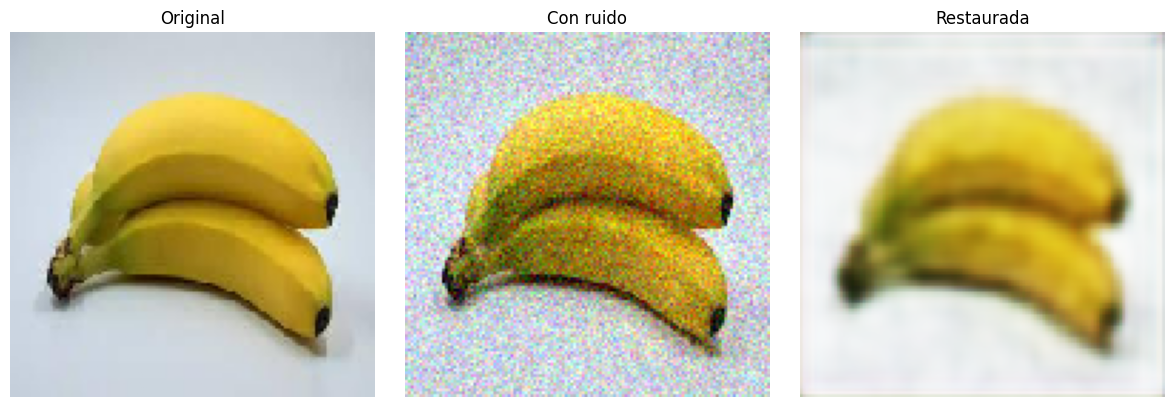

In [47]:
mostrar_resultados(64)

In [59]:
# 🧠 Inicializar Weights & Biases
WANDB_API_KEY = "b3f33eadf026fa8462e7b338032ce4018f13c31c"
wandb.login(key=WANDB_API_KEY)
wandb.init(project="vae-image-generation")

# ⚙️ Parámetros
LATENT_DIM = 16
INPUT_SHAPE = (128, 128, 3)



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: carlosalbertoml14 (carlosalbertoml14-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [60]:
# 🏗️ Encoder
encoder_inputs = Input(shape=INPUT_SHAPE)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [61]:
# 🏗️ Decoder
latent_inputs = Input(shape=(LATENT_DIM,))
x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

In [67]:
# 🧠 VAE personalizado
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2 )))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # 🔁 Log en W&B
        wandb.log({
    "total_loss": self.total_loss_tracker.result(),
    "reconstruction_loss": self.reconstruction_loss_tracker.result(),
    "kl_loss": self.kl_loss_tracker.result()
})

        # 🖼 Imagen generada
        sample = tf.random.normal(shape=(1, LATENT_DIM))
        generated = self.decoder(sample)[0].numpy()
        wandb.log({"generated_sample": wandb.Image(generated)})

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

# 🧪 Compilar y entrenar
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [68]:
# 👇 Sustituye estos con tus propios datos
# X_train, X_val = ...

vae.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=10,
    batch_size=32,
    callbacks=[
        [WandbCallback()]
    ]
)

# 💾 Guardar
vae.encoder.save("vae_encoder.h5")
vae.decoder.save("vae_decoder.h5")

Epoch 1/10


ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [74]:
# Código final del VAE completamente corregido con WandbMetricsLogger + generación de imágenes al final de cada epoch

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import numpy as np

# 🔐 Login y setup de W&B
WANDB_API_KEY = "b3f33eadf026fa8462e7b338032ce4018f13c31c"
wandb.login(key=WANDB_API_KEY)
wandb.init(project="vae-image-generation")

# ⚙️ Hiperparámetros
LATENT_DIM = 16
INPUT_SHAPE = (128, 128, 3)

# 🧱 Encoder
encoder_inputs = Input(shape=INPUT_SHAPE)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# 🧱 Decoder
latent_inputs = Input(shape=(LATENT_DIM,))
x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

# 🧠 Modelo VAE personalizado
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    # Agrega el método call() para la inferencia
    def call(self, inputs, training=None, mask=None):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)


# 🖼 Callback para loguear imágenes generadas por el VAE
class ImageLoggerCallback(keras.callbacks.Callback):
    def __init__(self, decoder, latent_dim):
        self.decoder = decoder
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        z_sample = tf.random.normal(shape=(1, self.latent_dim))
        generated = self.decoder.predict(z_sample)[0]
        wandb.log({"sampled_image": wandb.Image(generated, caption=f"Epoch {epoch + 1}")})

# 🧪 Preparar el modelo
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [75]:
# 👇 Reemplaza con tus datos reales
# Asegúrate de que estén normalizados entre 0 y 1 y tengan forma (N, 128, 128, 3)
# Ejemplo:
# X_train = np.load("X_train.npy")
# X_val = np.load("X_val.npy")

# 🚀 Entrenamiento con tracking completo en W&B
vae.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=10,
    batch_size=32,
    callbacks=[
        WandbMetricsLogger(),  # 🔢 Registra métricas automáticas
        WandbModelCheckpoint(filepath="vae_best.keras", save_best_only=True),  # 💾 Guarda el mejor modelo
        ImageLoggerCallback(decoder=decoder, latent_dim=LATENT_DIM)  # 🖼 Registra una imagen generada por epoch
    ]
)

# ✅ Guardar encoder y decoder por separado
encoder.save("vae_encoder.keras")
decoder.save("vae_decoder.keras")

print("✅ ¡Entrenamiento finalizado y modelos guardados!")


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - kl_loss: 62.2199 - loss: 11087.8984 - reconstruction_loss: 11025.6787

ValueError: No loss to compute. Provide a `loss` argument in `compile()`.

In [78]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

# -------------------------------
# 1. Configurar W&B
# -------------------------------
WANDB_API_KEY = "b3f33eadf026fa8462e7b338032ce4018f13c31c"
wandb.login(key=WANDB_API_KEY)
wandb.init(project="vae-image-generation")

# -------------------------------
# 2. Parámetros y definición de modelo
# -------------------------------
LATENT_DIM = 16
INPUT_SHAPE = (128, 128, 3)

# --- Encoder ---
encoder_inputs = Input(shape=INPUT_SHAPE)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# --- Decoder ---
latent_inputs = Input(shape=(LATENT_DIM,))
x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

# -------------------------------
# 3. Definición del VAE personalizado
# -------------------------------
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer, **kwargs):
        # Se requiere un loss dummy para que Keras no falle, ya que usamos train_step personalizado.
        super(VAE, self).compile(loss=lambda y_true, y_pred: 0, optimizer=optimizer, **kwargs)
        self.optimizer = optimizer
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # binary_crossentropy devuelve un tensor de forma [batch, height, width]
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def call(self, inputs, training=None, mask=None):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)

# -------------------------------
# 4. Callback para loguear imágenes generadas
# -------------------------------
class ImageLoggerCallback(keras.callbacks.Callback):
    def __init__(self, decoder, latent_dim):
        self.decoder = decoder
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        z_sample = tf.random.normal(shape=(1, self.latent_dim))
        generated = self.decoder.predict(z_sample)[0]
        wandb.log({"sampled_image": wandb.Image(generated, caption=f"Epoch {epoch + 1}")})

# -------------------------------
# 5. Preparar y compilar el modelo VAE
# -------------------------------
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

# -------------------------------
# 6. Crear directorio para guardar checkpoints
# -------------------------------
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# -------------------------------
# 7. Entrenamiento
# -------------------------------
# Asegúrate de que X_train y X_val estén definidos y normalizados (forma: (N, 128, 128, 3))
# Por ejemplo:
# X_train = np.load("X_train.npy")
# X_val = np.load("X_val.npy")
vae.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=10,
    batch_size=32,
    callbacks=[
        WandbMetricsLogger(),
        # Para evitar el error, guardamos siempre el checkpoint (save_best_only=False)
        WandbModelCheckpoint(filepath=os.path.join(checkpoint_dir, "vae_epoch_{epoch:02d}.keras"), save_best_only=False),
        ImageLoggerCallback(decoder=decoder, latent_dim=LATENT_DIM)
    ]
)

# -------------------------------
# 8. Guardar modelos
# -------------------------------
encoder.save("vae_encoder.keras")
decoder.save("vae_decoder.keras")
print("✅ ¡Entrenamiento finalizado y modelos guardados!")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - kl_loss: 94.0654 - loss: 11001.0146 - reconstruction_loss: 10906.9492 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - kl_loss: 34.4907 - loss: 9963.4834 - reconstruction_loss: 9928.9922 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - kl_loss: 36.2400 - loss: 9537.6338 - reconstruction_loss: 9501.3936 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - kl_loss: 34.8932 - loss: 9102.3516 - reconstruction_loss: 9067.4580 - val_kl_loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


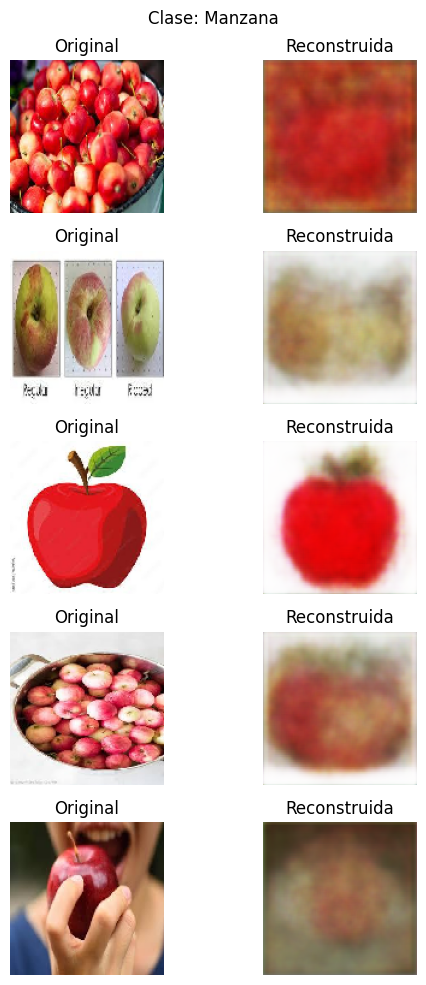

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


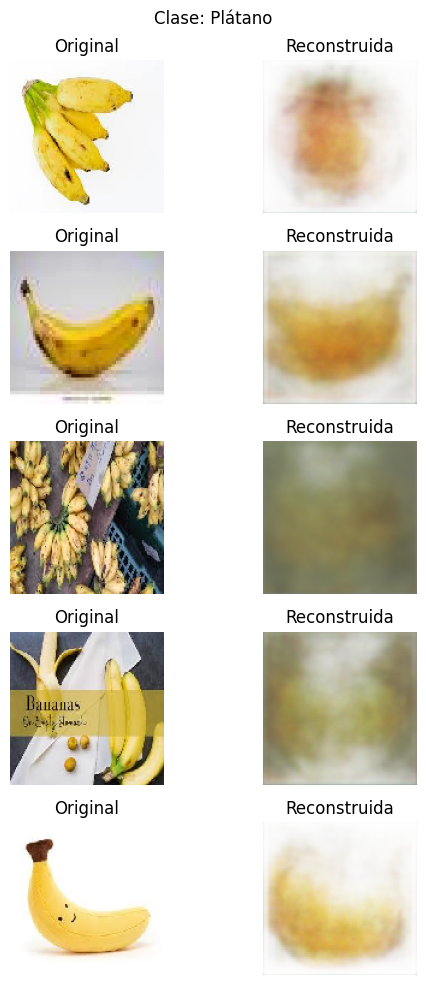

In [79]:
import matplotlib.pyplot as plt

def mostrar_imagenes_por_clase(vae, X, y, clase=0, cantidad=5):
    indices = np.where(y == clase)[0][:cantidad]
    imagenes = X[indices]
    reconstrucciones = vae.predict(imagenes)

    fig, axs = plt.subplots(cantidad, 2, figsize=(6, cantidad * 2))

    for i in range(cantidad):
        axs[i, 0].imshow(imagenes[i])
        axs[i, 0].set_title("Original")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(reconstrucciones[i])
        axs[i, 1].set_title("Reconstruida")
        axs[i, 1].axis("off")

    plt.suptitle(f"Clase: {'Manzana' if clase == 0 else 'Plátano'}")
    plt.tight_layout()
    plt.show()

# Mostrar 5 de cada clase
mostrar_imagenes_por_clase(vae, X_test, y_test, clase=0, cantidad=5)
mostrar_imagenes_por_clase(vae, X_test, y_test, clase=1, cantidad=5)


In [82]:
!git config --global user.email "carlosalbertoml14@gmail.com"
!git config --global user.name "Parcex10"

In [83]:
%cd /content/DAE-VAE
!git add trabajo_clonado.ipynb
!git commit -m "Añadir trabajo previo a la Interfaz con Gradio"
!git push origin main

/content/DAE-VAE
fatal: pathspec 'trabajo_clonado.ipynb' did not match any files
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address
